In [132]:
#import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
from tensorflow import keras
from medmnist import ChestMNIST
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from matplotlib.gridspec import GridSpec


In [119]:
#import data
x_train = ChestMNIST(root='./data', split='train', transform=None, download=True)
x_test = ChestMNIST(root='./data', split='test', transform=None, download=True)
x_train = x_train.imgs
x_test = x_test.imgs

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 784))
x_test = np.reshape(x_test, (len(x_test), 784))

Using downloaded and verified file: ./data/chestmnist.npz
Using downloaded and verified file: ./data/chestmnist.npz


In [135]:
def print_results(pca, autoencoder, cnn, x_test, x_test_noisy, n, name):
    decodedPCA = pca.inverse_transform(pca.transform(x_test_noisy))
    decodedDAE = autoencoder.predict(x_test_noisy)
    decodedCNN = cnn.predict(x_test_noisy.reshape(-1, 28, 28, 1)).reshape(-1, 784)
    fig = plt.figure(figsize=(10, 5))
    gs = GridSpec(2, 3, height_ratios=[1, 1]) 
    for i in range(n):
        ax = fig.add_subplot(gs[0,0:2])
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = fig.add_subplot(gs[0,1:3])
        plt.imshow(x_test_noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = fig.add_subplot(gs[1,0])
        plt.imshow(decodedPCA[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = fig.add_subplot(gs[1,1])
        plt.imshow(decodedDAE[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = fig.add_subplot(gs[1,2])
        plt.imshow(decodedCNN[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.savefig(name)

In [121]:
# Create the encoder
def dae(x_train, x_train_noisy, x_test, x_test_noisy, latent_dim):
    start = time.time()

    input_img = keras.layers.Input(shape=(784,))
    encoded = keras.layers.Dense(128, activation='relu')(input_img)
    encoded = keras.layers.Dense(64, activation='relu')(encoded)
    encoded = keras.layers.Dense(latent_dim, activation='relu')(encoded)

    decoded = keras.layers.Dense(64, activation='relu')(encoded)
    decoded = keras.layers.Dense(128, activation='relu')(decoded)
    decoded = keras.layers.Dense(784, activation='sigmoid')(decoded)

    autoencoder = keras.models.Model(input_img, decoded)
    autoencoder.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError())

    #train
    autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=64, shuffle=True, validation_data=(x_test_noisy, x_test))

    #test
    decoded_imgs = autoencoder.predict(x_test_noisy)
    end = time.time()

    mse = keras.losses.MeanSquaredError()
    return autoencoder, mse(x_test, decoded_imgs).numpy(), end - start


In [122]:
# Create the encoder
def cnn_dae(x_train, x_train_noisy, x_test, x_test_noisy, latent_dim):
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
    x_test_noisy = np.reshape(x_test_noisy, (len(x_test_noisy), 28, 28, 1))
    x_train_noisy = np.reshape(x_train_noisy, (len(x_train_noisy), 28, 28, 1))
    start = time.time()
    autoencoder = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2), padding='same'),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2), padding='same'),
        keras.layers.Flatten(),
        keras.layers.Dense(latent_dim, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(784, activation='sigmoid'),
        keras.layers.Reshape((28, 28, 1)),
    ])
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    #train
    autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=64, shuffle=True, validation_data=(x_test_noisy, x_test))

    #test
    decoded_imgs = autoencoder.predict(x_test_noisy)
    end = time.time()

    mse = keras.losses.MeanSquaredError()
    return autoencoder, mse(x_test, decoded_imgs).numpy(), end - start


In [123]:
# create PCA
def pca(x_train_noisy,x_test,x_test_noisy, latent_dim):
    start = time.time()
    pca = PCA(n_components=latent_dim)
    pca.fit(x_train_noisy)
    x_test_pca = pca.transform(x_test_noisy)
    decoded_imgs_test = pca.inverse_transform(x_test_pca)
    end = time.time()

    mse_value = mean_squared_error(x_test.flatten(), decoded_imgs_test.flatten())  # Flatten per comparare le immagini
    return pca, mse_value, end - start


In [124]:
#add gaussian noise
noise_factor = 1
np.random.seed(674)
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy_2 = x_train_noisy + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_pca = np.vstack((x_train_noisy, x_train_noisy_2))
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)    

In [126]:
#plot results
pca_trial, pca_mse, pca_time = pca(x_train_pca, x_test, x_test_noisy, 20)
dae_trial, dae_mse, dae_time = dae(x_train_noisy_2, x_train_noisy, x_test, x_test_noisy, 20)
cnn_dae_trial, cnn_dae_mse, cnn_dae_time = cnn_dae(x_train_noisy_2, x_train_noisy, x_test, x_test_noisy, 20)


Epoch 1/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 2.0240 - val_loss: 0.0258
Epoch 2/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.0035 - val_loss: 0.0239
Epoch 3/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.9968 - val_loss: 0.0247
Epoch 4/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.9949 - val_loss: 0.0254
Epoch 5/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.9947 - val_loss: 0.0245
Epoch 6/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.9938 - val_loss: 0.0259
Epoch 7/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.9932 - val_loss: 0.0246
Epoch 8/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.9929 - val_loss: 0.0264
Epoch 9/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.9933 - val_loss: 0.0251
Epoch 10/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.9914 - val_loss: 0.0249
702/702 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 66s 48ms/step - loss: 2.0228 - val_loss: 0.0187
Epoch 2/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 2.0096 - val_loss: 0.0177
Epoch 3/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - loss: 2.0087 - val_loss: 0.0177
Epoch 4/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 78s 38ms/step - loss: 2.0083 - val_loss: 0.0176
Epoch 5/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - loss: 2.0087 - val_loss: 0.0175
Epoch 6/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - loss: 2.0081 - val_loss: 0.0174
Epoch 7/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - loss: 2.0078 - val_loss: 0.0179
Epoch 8/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - loss: 2.0077 - val_loss: 0.0175
Epoch 9/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 51s 42ms/step - loss: 2.0075 - val_loss: 0.0179
Epoch 10/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - loss: 2.0070 - val_loss: 0.0175
702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
702/702 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
PCA MSE:  0.02895586575225355  Time:  3.337048053741455
DAE MSE:  0.024949022  Time:  62.71557092666626


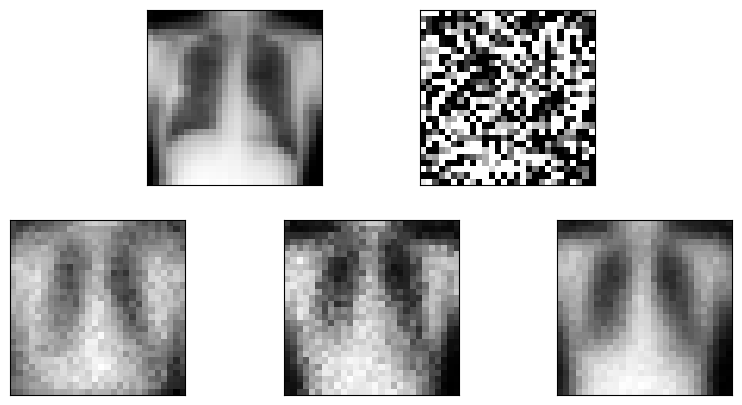

In [136]:
print_results(pca_trial, dae_trial, cnn_dae_trial, x_test, x_test_noisy, 1, 'results_gaussian.png')
print("PCA MSE: ", pca_mse, " Time: ", pca_time)
print("DAE MSE: ", dae_mse, " Time: ", dae_time)

In [ ]:
#run trials
dims = [4,6,8,10,12,14]

errPCA_gaussian = np.array([])
errDAE_gaussian = np.array([])
errCNN_gaussian = np.array([])
timePCA_gaussian = np.array([])
timeDAE_gaussian = np.array([])
timeCNN_gaussian = np.array([])

for dim in dims:
    pca_trial, pca_mse, pca_time = pca(x_train_pca, x_test, x_test_noisy, dim)
    dae_trial, dae_mse, dae_time = dae(x_train_noisy_2, x_train_noisy, x_test, x_test_noisy, dim)
    cnn_dae_trial, cnn_dae_mse, cnn_dae_time = cnn_dae(x_train_noisy_2, x_train_noisy, x_test, x_test_noisy, dim)
    errPCA_gaussian = np.append(errPCA_gaussian, pca_mse)
    errDAE_gaussian = np.append(errDAE_gaussian, dae_mse)
    errCNN_gaussian = np.append(errCNN_gaussian, cnn_dae_mse)
    timePCA_gaussian = np.append(timePCA_gaussian, pca_time)
    timeDAE_gaussian = np.append(timeDAE_gaussian, dae_time)
    timeCNN_gaussian = np.append(timeCNN_gaussian, cnn_dae_time)

In [ ]:
#plot mse
plt.figure(figsize=(10, 5))
plt.plot(dims, errPCA_gaussian, label='PCA', marker='o', color='r', linewidth=3, markersize=10)
plt.plot(dims, errDAE_gaussian, label='DAE', marker='o', color='b', linewidth=3, markersize=10)
plt.plot(dims, errCNN_gaussian, label='CNN-DAE', marker='o', color='g', linewidth=3, markersize=10)
plt.xlabel('Latent dimension/Number of components', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig('validation_gaussian.eps')

In [ ]:
#plot runtime
plt.figure(figsize=(10, 5))
plt.semilogy(dims, timePCA_gaussian, label='PCA', marker='o', color='r', linewidth=3, markersize=10)
plt.semilogy(dims, timeCNN_gaussian, label='CNN-DAE', marker='o', color='g', linewidth=3, markersize=10)
plt.semilogy(dims, timeDAE_gaussian, label='DAE', marker='o', color='b', linewidth=3, markersize=10)
plt.xlabel('Latent dimension/Number of components', fontsize=16)
plt.ylabel('Runtime [s]', fontsize=16)
plt.legend(fontsize=13, loc='lower right')
plt.ylim(1, 1100)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig('runtime_gaussian.eps')

In [137]:
#add low frequency noise
matrix_train = np.array([np.linspace(0,np.random.randint(10,35)*np.pi,784) for i in range(x_train.shape[0])])
matrix_train_2 = np.array([np.linspace(0,np.random.randint(10,35)*np.pi,784) for i in range(x_train.shape[0])])
matrix_test = np.array([np.linspace(0,np.random.randint(10,35)*np.pi,784) for i in range(x_test.shape[0])])
x_train_noisy = x_train + 0.2 * np.sin(matrix_train+2*np.pi*np.random.rand(x_train.shape[0])[:,None])
x_train_noisy_2 = x_train_noisy + 0.2 * np.sin(matrix_train_2+2*np.pi*np.random.rand(x_train.shape[0])[:,None])
x_train_pca = np.vstack((x_train_noisy, x_train_noisy_2))
x_test_noisy = x_test + 0.2 * np.sin(matrix_test+2*np.pi*np.random.rand(x_test.shape[0])[:,None])
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Epoch 1/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0557 - val_loss: 0.0115
Epoch 2/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0439 - val_loss: 0.0111
Epoch 3/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0425 - val_loss: 0.0128
Epoch 4/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0409 - val_loss: 0.0149
Epoch 5/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0389 - val_loss: 0.0162
Epoch 6/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0372 - val_loss: 0.0178
Epoch 7/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0356 - val_loss: 0.0201
Epoch 8/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0342 - val_loss: 0.0208
Epoch 9/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0332 - val_loss: 0.0217
Epoch 10/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0324 - val_loss: 0.0223
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 59s 43ms/step - loss: 0.0560 - val_loss: 0.0073
Epoch 2/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - loss: 0.0460 - val_loss: 0.0074
Epoch 3/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - loss: 0.0456 - val_loss: 0.0076
Epoch 4/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - loss: 0.0454 - val_loss: 0.0076
Epoch 5/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - loss: 0.0452 - val_loss: 0.0077
Epoch 6/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - loss: 0.0450 - val_loss: 0.0078
Epoch 7/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - loss: 0.0448 - val_loss: 0.0082
Epoch 8/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - loss: 0.0445 - val_loss: 0.0084
Epoch 9/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - loss: 0.0444 - val_loss: 0.0086
Epoch 10/10
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - loss: 0.0443 - val_loss: 0.0086
702/702 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
702/702 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
702/702 ━━━━━━━━━

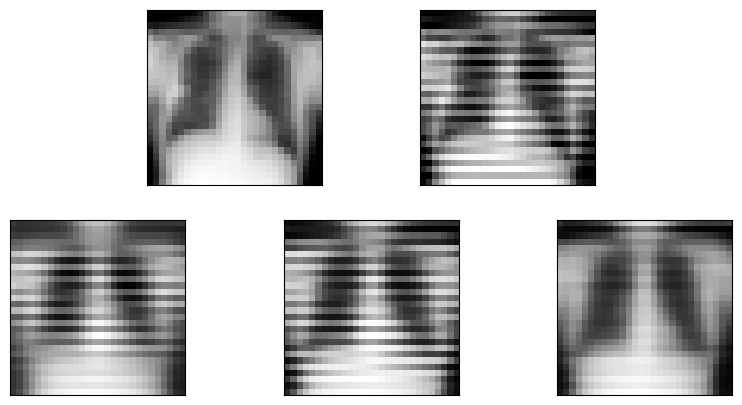

In [138]:
#plot results
pca_trial, pca_mse, pca_time = pca(x_train_noisy, x_test, x_test_noisy, 20)
dae_trial, dae_mse, dae_time = dae(x_train_noisy_2, x_train_noisy, x_test, x_test_noisy, 20)
cnn_dae_trial, cnn_dae_mse, cnn_dae_time = cnn_dae(x_train_noisy_2, x_train_noisy, x_test, x_test_noisy, 20)
print_results(pca_trial, dae_trial, cnn_dae_trial, x_test, x_test_noisy, 1, 'results_lf.png')

In [ ]:
#run trials
mindim = 4
maxdim = 18
step = 2
dims = range(mindim, maxdim, step)

errPCA_lf = np.array([])
errDAE_lf = np.array([])
errCNN_lf = np.array([])
timePCA_lf = np.array([])
timeDAE_lf = np.array([])
timeCNN_lf = np.array([])
for dim in dims:
    pca_trial, pca_mse, pca_time = pca(x_train_pca, x_test, x_test_noisy, dim)
    dae_trial, dae_mse, dae_time = dae(x_train_noisy_2, x_train_noisy, x_test, x_test_noisy, dim)
    cnn_dae_trial, cnn_dae_mse, cnn_dae_time = cnn_dae(x_train_noisy_2,x_train_noisy,x_test,x_test_noisy,dim)
    errPCA_lf = np.append(errPCA_lf, pca_mse)
    errDAE_lf = np.append(errDAE_lf, dae_mse)
    errCNN_lf = np.append(errCNN_lf,cnn_dae_mse)
    timePCA_lf = np.append(timePCA_lf, pca_time)
    timeDAE_lf = np.append(timeDAE_lf, dae_time)
    timeCNN_lf = np.append(timeCNN_lf, cnn_dae_time)

In [ ]:
#plot mse
plt.figure(figsize=(10, 5))
plt.plot(dims, errPCA_lf, label='PCA', marker='o', color='r', linewidth=3, markersize=10)
plt.plot(dims, errDAE_lf, label='DAE', marker='o', color='b', linewidth=3, markersize=10)
plt.plot(dims, errCNN_lf, label='CNN', marker='o', color='g', linewidth=3, markersize=10)
plt.xlabel('Latent dimension/Number of components', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig('validation_low_freq.eps')

In [ ]:
#plot runtime
plt.figure(figsize=(10, 5))
plt.semilogy(dims, timePCA_lf, label='PCA', marker='o', color='r', linewidth=3, markersize=10)
plt.semilogy(dims, timeDAE_lf, label='DAE', marker='o', color='b', linewidth=3, markersize=10)
plt.semilogy(dims, timeCNN_lf, label='CNN', marker='o', color='g', linewidth=3, markersize=10)
plt.xlabel('Latent dimension/Number of components', fontsize=16)
plt.ylabel('Runtime [s]', fontsize=16)
plt.legend(fontsize=16)
plt.ylim(1, 1100)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig('runtime_low_freq.eps')